# Predictive Distribution
Calc JS divergence using distribution by predictive

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import arviz as az
from scipy.stats import norm, entropy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Methods

In [2]:
def sturges_rule(n: int) -> int:
    '''スタージェスの公式'''
    return int(round(1 + np.log2(n)))

In [3]:
def normalize(sr: pd.Series) -> pd.Series:
    '''正規化'''
    return sr / sr.sum()

In [4]:
def jensen_shannon_divergence(lis: list) -> np.array:
    '''JSダイバージェンス'''
    length = len(lis)
    res = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            p = normalize(lis[i]).values
            q = normalize(lis[j]).values
            m = (p + q) / 2
            kl_pm = entropy(p, m)
            kl_qm = entropy(q, m)
            js = (kl_pm + kl_qm) / 2
            res[i, j] = js
    return res

## Iris Data Set

In [5]:
df_iris = pd.read_csv('iris.csv')

In [90]:
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Describe

### setosa

In [9]:
df_iris_setosa = df_iris.query('species=="setosa"')

In [10]:
df_iris_setosa.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,50.00000,50.000000,50.000000,50.000000
mean,5.00600,3.428000,1.462000,0.246000
std,0.35249,0.379064,0.173664,0.105386
min,4.30000,2.300000,1.000000,0.100000
25%,4.80000,3.200000,1.400000,0.200000
50%,5.00000,3.400000,1.500000,0.200000
75%,5.20000,3.675000,1.575000,0.300000
max,5.80000,4.400000,1.900000,0.600000


### virginica

In [11]:
df_iris_virginica = df_iris.query('species=="virginica"')

In [12]:
df_iris_virginica.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,50.00000,50.000000,50.000000,50.00000
mean,6.58800,2.974000,5.552000,2.02600
std,0.63588,0.322497,0.551895,0.27465
min,4.90000,2.200000,4.500000,1.40000
25%,6.22500,2.800000,5.100000,1.80000
50%,6.50000,3.000000,5.550000,2.00000
75%,6.90000,3.175000,5.875000,2.30000
max,7.90000,3.800000,6.900000,2.50000


### versicolor

In [13]:
df_iris_versicolor = df_iris.query('species=="versicolor"')

In [14]:
df_iris_versicolor.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,50.000000,50.000000,50.000000,50.000000
mean,5.936000,2.770000,4.260000,1.326000
std,0.516171,0.313798,0.469911,0.197753
min,4.900000,2.000000,3.000000,1.000000
25%,5.600000,2.525000,4.000000,1.200000
50%,5.900000,2.800000,4.350000,1.300000
75%,6.300000,3.000000,4.600000,1.500000
max,7.000000,3.400000,5.100000,1.800000


## Bayesian Estimation
Calc predictive distribution

In [240]:
with pm.Model() as model:
    mu     = pm.Uniform('mu', 0, 100)
    sigma  = pm.Uniform('sigma', 0, 100)
    y_pred = pm.Normal('y_pred', mu=mu, sd=sigma, observed=df_iris_setosa['sepal_length'].values)
    trace  = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:08<00:00, 1233.53draws/s]
The acceptance probability does not match the target. It is 0.8890939525453614, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,5.005416,0.050504,0.000644,4.902922,5.101047,7448.511439,0.999876
sigma,0.362265,0.037990,0.000493,0.290962,0.436249,7077.248077,1.000146


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16d20cc18>,
      dtype=object)

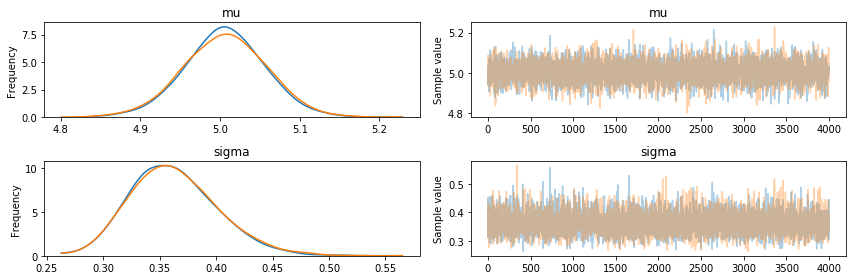

In [241]:
chain = trace[1000:]
display(pm.summary(chain))
display(pm.traceplot(chain))

In [251]:
summary = pm.summary(chain)
summary.loc['mu','mean']

5.005416170182644

In [247]:
post_pred = pm.sample_posterior_predictive(trace, samples=1000000, model=model)

5.005650676742937

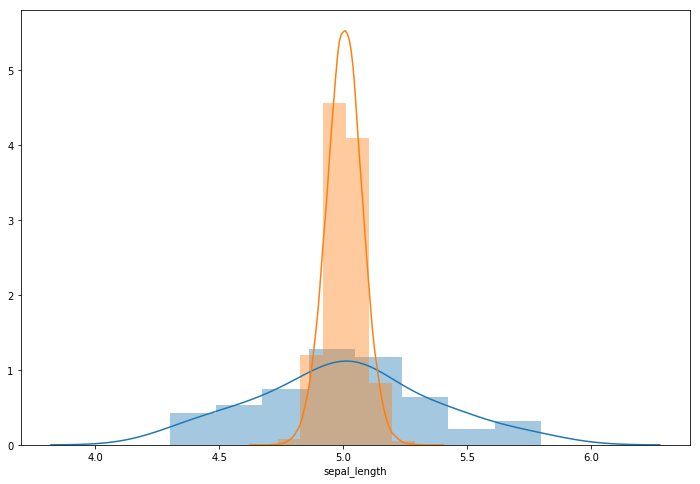

In [249]:
plt.figure(figsize=(12,8))
sns.distplot(df_iris_setosa['sepal_length'], kde=True, rug=False, bins=bins)
sns.distplot([n.mean() for n in post_pred['y_pred']], kde=True, rug=False, bins=bins)
# sns.distplot(post_pred['y_pred'].mean(axis=1), kde=True, rug=False, bins=bins)